# HELLO EVERYONE 
### The present pipeline is designed for amplicon/metagenome/metabarcoding analysis using the R package DADA2. This automated workflow is aimed to be useful for any metagenomic analysis using Illumina sequences.  

## DADA2: 
### Here we will use DADA2 as a starting point to process reads until generating a table of Amplicon Sequence Variants (ASV). 

### This workflow assumes that your sequencing data meets certain criteria:
    1)Samples have been demultiplexed
    2)Non-biological nucleotides have been removed (CUTADAPT step)

## The steps to follow from the pipeline to the ASV table are:
- Set the workspace
- Filter and Trim
- Dereplicate
- Learn Error Rates
- Infer sample composition
- Merge paired reads
- Remove chimeras
- Get sequence table
- Assign Taxonomy

### Setting up our workspace
    First we have to load the DADA2 package (library(dada2)), then generate random pseudonumbers (set.seed(100)). Next let's see where we are located on the server. Finally we will place ourselves in the directory where our reads are located. 

In [1]:
library(dada2) 
set.seed(100)
getwd()

Loading required package: Rcpp



[1] "/home/usuario/Documentos/YARINACOCHA_16S"

In [2]:
path <- '/home/usuario/Documentos/YARINACOCHA_16S'

### Get matched lists of the forward and reverse fastq files

In [3]:
fnFs <- sort(list.files(path, pattern="_R1.fastq", full.names = TRUE))
fnRs <- sort(list.files(path, pattern="_R2.fastq", full.names = TRUE))

### Extract sample names, assuming filenames have format: SAMPLENAME_XXX.fastq

In [4]:
sample.names <- sapply(strsplit(basename(fnFs), "_"), `[`, 1)

### Specify the full path to the fnFs and fnRs:
THE FILTERED READS WILL BE PLACED IN THE DIRECTORY "FILTERED".

In [5]:
filtFs <- file.path(path, "filtered", paste0(sample.names, "_F_filt.fastq.gz"))
filtRs <- file.path(path, "filtered", paste0(sample.names, "_R_filt.fastq.gz"))

### Let's visualize how you’re reads are doing:
    -DADA2 allows quality plotting of Forward and Reverse reads.

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


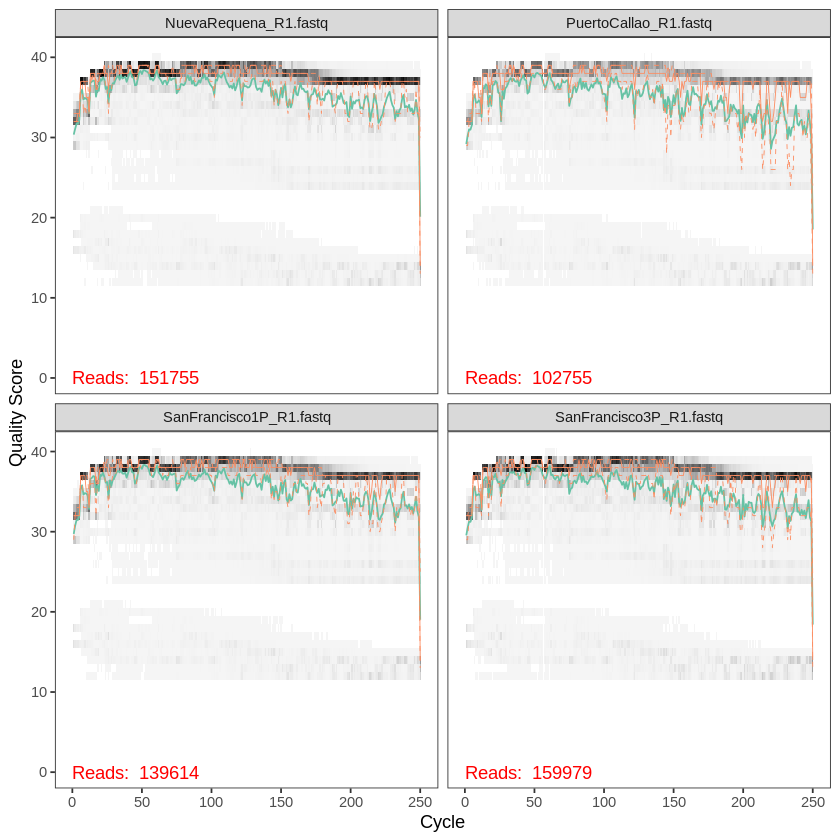

In [6]:
plotQualityProfile(fnFs)

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


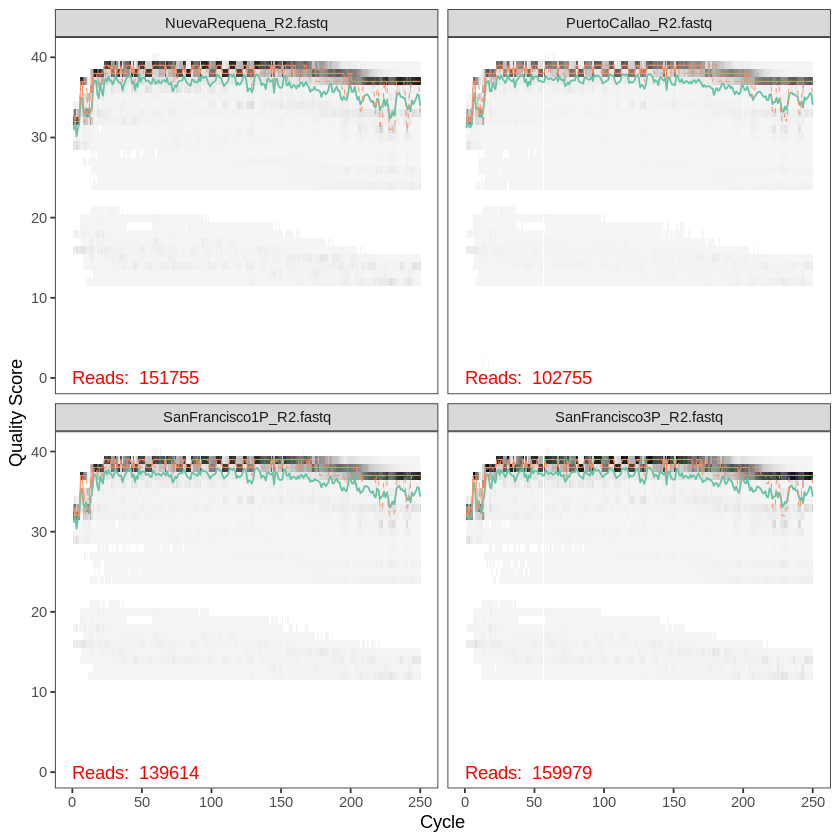

In [7]:
plotQualityProfile(fnRs)

## Filter and Trim the forward and reverse reads : 
We’ll use standard filtering parameters: maxN=0 (DADA2 requires no Ns), truncQ=2, rm.phix=TRUE and maxEE=2.
The maxEE parameter sets the maximum number of “expected errors” allowed in a read, which is a better filter than simply averaging quality scores.

I’m going to cut or truncate the forward reads at 225 and the reverse reads at 250. That's why the quality drops at that position. 

TrimLeft is used for for remove adapters.

In [8]:
out <- filterAndTrim(fnFs, filtFs, fnRs, filtRs, maxN=0, rm.phix=TRUE, maxEE = 2, truncLen = c(225,250), trimLeft = c(17,21), compress=TRUE, multithread=TRUE)

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


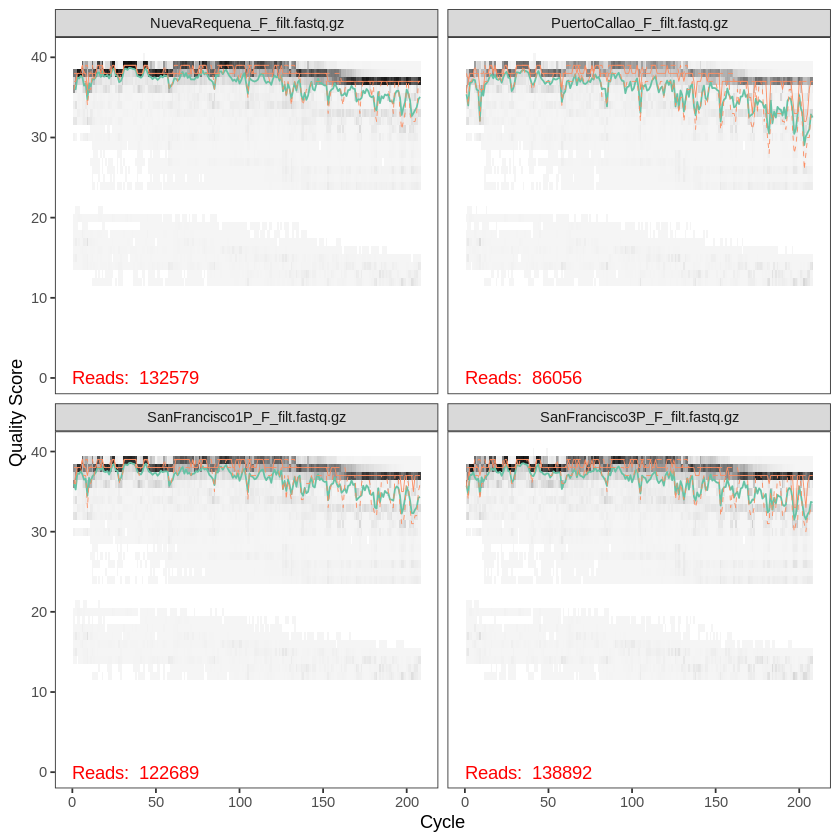

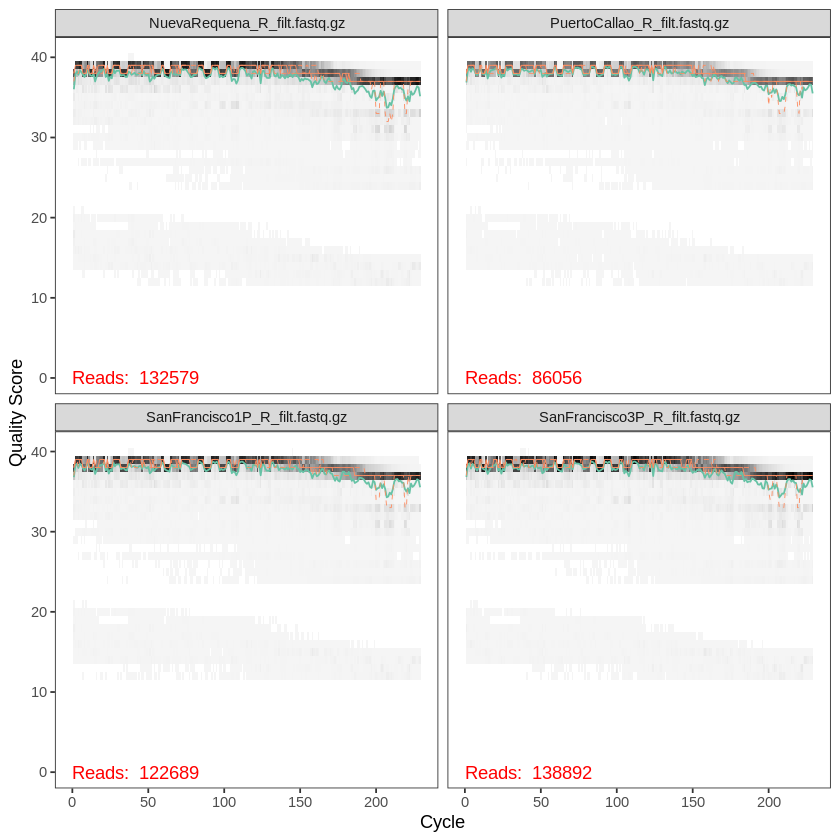

In [9]:
plotQualityProfile(filtFs)
plotQualityProfile(filtRs)

The function filterAndTrim () is capable to filter reverse and forward reads jointly. 

## Dereplication (optional)

In [10]:
#derepFs <- derepFastq(filtFs, verbose=TRUE)
#derepRs <- derepFastq(filtRs, verbose=TRUE)

## Visualize the estimated error rates

In [11]:
errF <- learnErrors(filtFs, multithread = TRUE)
errR <- learnErrors(filtRs, multithread = TRUE)

99884928 total bases in 480216 reads from 4 samples will be used for learning the error rates.
109969464 total bases in 480216 reads from 4 samples will be used for learning the error rates.


## DADA, inferring ASVs: 
### Infer sample composition

In [12]:
dadaFs <- dada(filtFs, err=errF, multithread = TRUE)
dadaRs <- dada(filtRs, err=errR, multithread = TRUE)

Sample 1 - 132579 reads in 41126 unique sequences.
Sample 2 - 86056 reads in 27911 unique sequences.
Sample 3 - 122689 reads in 35917 unique sequences.
Sample 4 - 138892 reads in 47384 unique sequences.
Sample 1 - 132579 reads in 41817 unique sequences.
Sample 2 - 86056 reads in 22417 unique sequences.
Sample 3 - 122689 reads in 33020 unique sequences.
Sample 4 - 138892 reads in 43422 unique sequences.


## Merge forward/reverse reads and get a sequence table
    -Using the function mergePairs() it's posible to merge forwards and revers reads 
    -With the function makeSequenceTable() we create a table of sequences.

112532 paired-reads (in 1062 unique pairings) successfully merged out of 125792 (in 4609 pairings) input.

78281 paired-reads (in 545 unique pairings) successfully merged out of 83342 (in 1906 pairings) input.

114265 paired-reads (in 871 unique pairings) successfully merged out of 119462 (in 2349 pairings) input.

119758 paired-reads (in 1076 unique pairings) successfully merged out of 132195 (in 4517 pairings) input.




 229  234  235  236  239  240  242  244  247  250  251  252  253  254  255  256 
   2    1    1    2    1    1    1    1    3    1    4   13   42 1900  127   14 
 257  258  260  274  277  284  294  307  312  316  339  348  408  410  415  416 
   5    2    2    1    1    1    1    1    1    1    1    1    1    1    1    4 
 417  419  421  422  425 
  18    3    1    1    4 

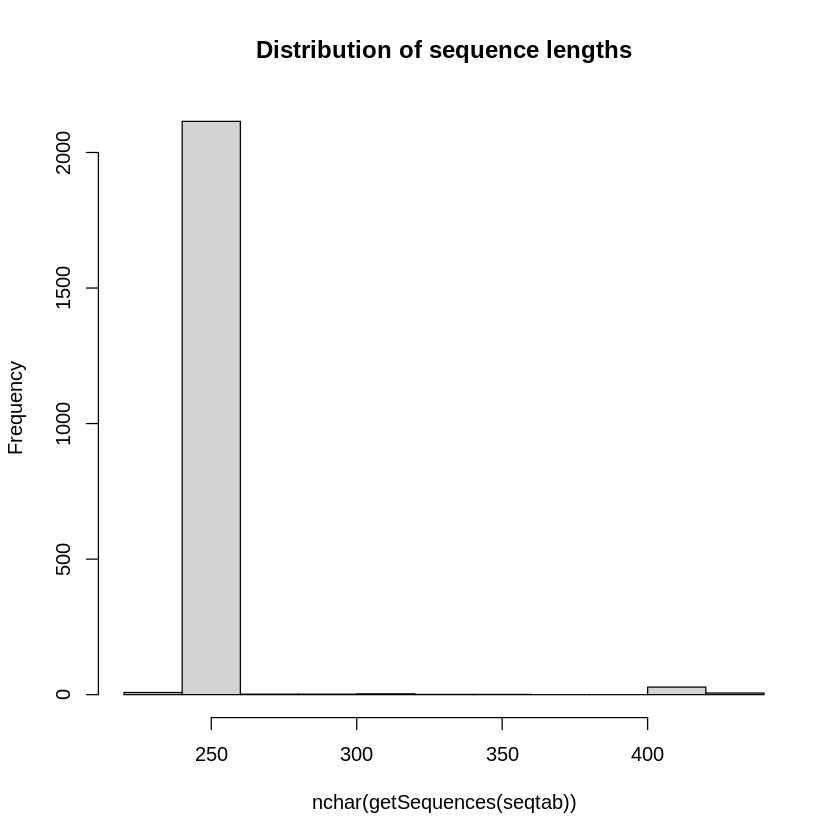

In [13]:
mergers <- mergePairs(dadaFs, filtFs, dadaRs, filtRs, verbose=TRUE)
seqtab <- makeSequenceTable(mergers)
table(nchar(getSequences(seqtab)))
hist(nchar(getSequences(seqtab)), main="Distribution of sequence lengths")


 229  234  235  236  239  240  242  244  247  250  251  252  253  254  255  256 
   2    1    1    2    1    1    1    1    3    1    4   13   42 1900  127   14 
 257  258  260  274  277  284  294 
   5    2    2    1    1    1    1 

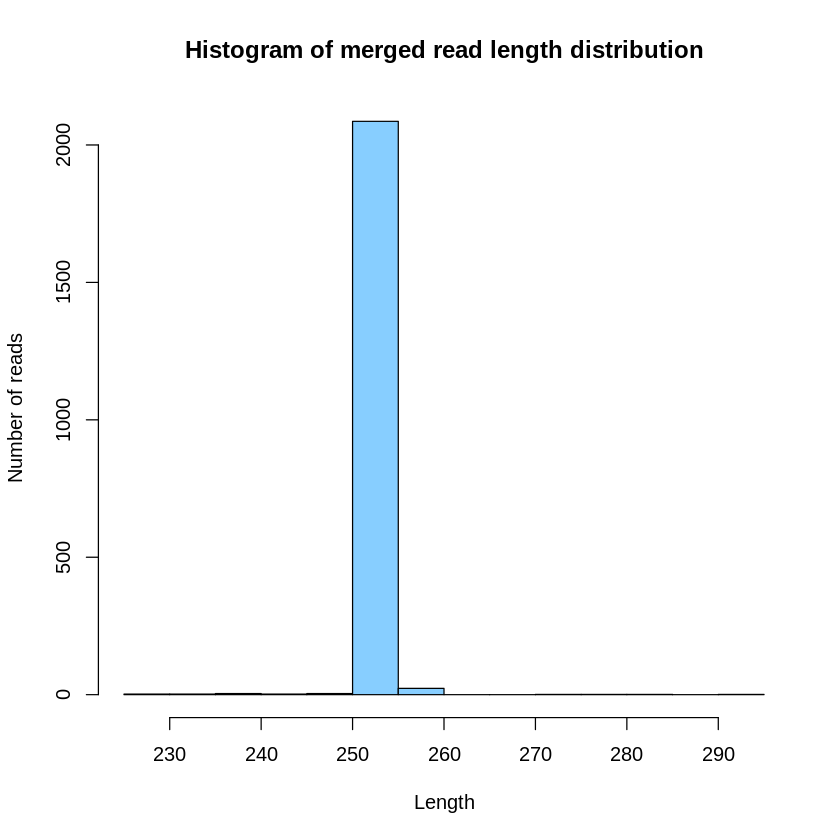

In [14]:
seqtab2 <- seqtab[,nchar(colnames(seqtab)) %in% 220:300]
table(nchar(getSequences(seqtab2)))
hist(nchar(getSequences(seqtab2)), main = "Histogram of merged read length distribution", xlab = "Length", ylab = "Number of reads", col = "skyblue1")

## Removing quimeras 
    -Using removeBimeraDenovo: Remove quimeric sequences 
    -sum() we identifie the percentage of quimeric sequences

In [15]:
seqtab.nochim <- removeBimeraDenovo(seqtab2, method="consensus", multithread=TRUE, verbose=TRUE)
sum(seqtab.nochim)/sum(seqtab2)

Identified 668 bimeras out of 2127 input sequences.



[1] 0.8718381

In [16]:
getN <- function(x) sum(getUniques(x))
track <- cbind(out, sapply(dadaFs, getN), sapply(dadaRs, getN), sapply(mergers, getN), rowSums(seqtab.nochim))
colnames(track) <- c("input", "filtered", "denoisedF", "denoisedR", "merged", "nonchim")
rownames(track) <- sample.names
View(track)
write.table(x = track, file = "reads-stats.txt", sep = "\t", quote = FALSE)

,input,filtered,denoisedF,denoisedR,merged,nonchim
NuevaRequena,151755,132579,129118,127737,112532,92562
PuertoCallao,102755,86056,84675,84092,78281,71725
SanFrancisco1P,139614,122689,121010,120420,114265,106890
SanFrancisco3P,159979,138892,135332,133995,119758,98859


## For save work space (checkpoint)

In [17]:
saveRDS(seqtab.nochim, "16sall.rds")
save.image("16s.RData")

## Assingation of taxonomy 

In [18]:
taxSilva <- assignTaxonomy(seqtab.nochim, '/home/usuario/Documentos/YARINACOCHA/silva_nr_v138_train_set.fa.gz', multithread=TRUE, minBoot = 80, tryRC=TRUE)

In [19]:
speciesSilva <- addSpecies(taxSilva, '/home/usuario/Documentos/YARINACOCHA/silva_species_assignment_v138.fa.gz', tryRC = TRUE, n = 10000)

## Creating a taxa table: 
    -It's a table containing taxonomy information: "Kingdom", "Phylum", "Class", "Order", "Family", "Genus"

In [20]:
write.table(taxSilva, file = "taxSilva.tsv", sep = "\t")
write.table(speciesSilva, file = "speciesSilva.tsv", sep = "\t")

## Creating main files 

## Identify ASV number: (I got 1459 ASVs):
    Each ASV correspond to a taxonomic clasification
    '>ASV_1''>ASV_2''>ASV_3''>ASV_4''>ASV_5''>ASV_6 ... '>ASV_1459'
### For example: 
    ASV Kingdom Phylum Class Order Family Genus
    ASV_1 Bacteria Cyanobacteria Cyanobacteriia Synechococcales Cyanobiaceae Cyanobium_PCC-6307
    

In [21]:
asv_seqs <- colnames(seqtab.nochim)
asv_headers <- vector(dim(seqtab.nochim)[2], mode="character")
for (i in 1:dim(seqtab.nochim)[2]) {
  asv_headers[i] <- paste(">ASV", i, sep="_")
}

### TAXONOMY TABLE (tax table / asv_tax)

In [22]:
asv_tax <- taxSilva
row.names(asv_tax) <- sub(">", "", asv_headers)
write.table(asv_tax, "ASVs_taxonomy.nov.tsv", sep="\t", quote=F, col.names=NA)

### TAXONOMY TABLE FOR SPECIES (tax table species / asv_tax_sp)

In [23]:
asv_tax_sp <- speciesSilva
row.names(asv_tax_sp) <- sub(">", "", asv_headers)
write.table(asv_tax_sp, "ASVs_taxonomy_sp.nov.tsv", sep="\t", quote=F, col.names=NA)

### FULL SEQUENCES: will bind asv numbers and sequences
    This is going to bind the headers of ASVs and sequeces of ASVs

In [24]:
asv_fasta <- c(rbind(asv_headers, asv_seqs))
write(asv_fasta, "ASVs.nov.fa")

### Count table named: asv_tab
     Here we'll a count table containing the counts of ASVs

In [25]:
asv_tab <- t(seqtab.nochim)
row.names(asv_tab) <- sub(">", "", asv_headers)
write.table(asv_tab, "ASVs_counts.nov.tsv", sep="\t", quote=F, col.names=NA)

# WORKING WITH METADATA

### I created a metadata called matadata_yarina in tsv format and csv format:
  #### Create a metadata in excel -> dowload in csv or tsv format
     Metadata is unique for each project, if you want (as me) you can modify an pre-existing metadata
     In my case, i modified an metadata where i only changed the sample's name, and color.

In [26]:
sample_info_tab <- read.csv("yarinacocha_metadata.csv", header= TRUE, row.names=1,
                   check.names=FALSE, sep=",")
sample_info_tab$color <- as.character(sample_info_tab$color_type)
sample_info_tab$color <- as.character(sample_info_tab$color_Lake)
sample_info_tab

,position,type,color_type,color_Lake,location,ASVs,color
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
NuevaRequena,MIDDLE,lake,#04de1a,#009E73,NuevaRequena,92562,#009E73
PuertoCallao,MIDDLE,lake,#04de1a,#009E73,PuertoCallao,71725,#009E73
SanFrancisco1P,UPPER,lake,#ff49bd,#CC79A7,SanFrancisco1P,106890,#CC79A7
SanFrancisco3P,UPPER,lake,#ff49bd,#CC79A7,SanFrancisco3P,98859,#CC79A7


## REQUIRED PACKAGES
    There are some importants R packages that we're gonna use for our analysis. Like phyloseq or DESeq2


In [27]:
library(tidyverse)
library(phyloseq)
library(vegan)
library(DESeq2)
library(dendextend)
library(viridis)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-7

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The fo

## LOADING COUNT TABLE AND TAX TABLE
    At this point our's previous files that we created will be load BUT as matrix. Thats because some R packages work only with matix. 

In [50]:
count_tab <- as.matrix(read.table("ASVs_counts.nov.tsv"), header = TRUE, row.names = 1, check.names = FALSE, sep = "\t")
tax_tab <- as.matrix(read.table("ASVs_taxonomy.nov.tsv"), header = TRUE, row.names = 1, check.names = FALSE, sep = "\t")
tax_tab_sp <- as.matrix(read.table("speciesSilva.tsv", header=T, row.names=1, check.names=FALSE, sep="\t"))

    Here, I suggest change location's names. I changed the names of the file created "ASV_counts.nov.tsv". 
    That's beceause is better to work with comprehensive name and for avoid future error. At firts the end of colum's name ends with "_F.filt.fastq.gz" and let's errease that part. i.e. PuertoCallao_F_filt.fastq.gz -> PuertoCallao

In [51]:
head(count_tab)

,NuevaRequena,PuertoCallao,SanFrancisco1P,SanFrancisco3P
ASV_1,9137,11275,11283,11681
ASV_2,770,132,15075,10338
ASV_3,13733,4895,1419,2066
ASV_4,4376,7539,3805,3681
ASV_5,3173,6993,1444,1369
ASV_6,3835,3461,2578,1874


# DESeq2

* Let's normalise the samples using a variance-stabilising transformation. 
* Then, we are going to use Euclidean distances to generate some exploratory visualisations of our samples.

In [52]:
deseq_counts <- DESeqDataSetFromMatrix(count_tab, colData = sample_info_tab, design = ~1)
deseq_counts <- estimateSizeFactors(deseq_counts, type = "poscounts")
deseq_counts_vst <- varianceStabilizingTransformation(deseq_counts)
vst_trans_count_tab <- assay(deseq_counts_vst)

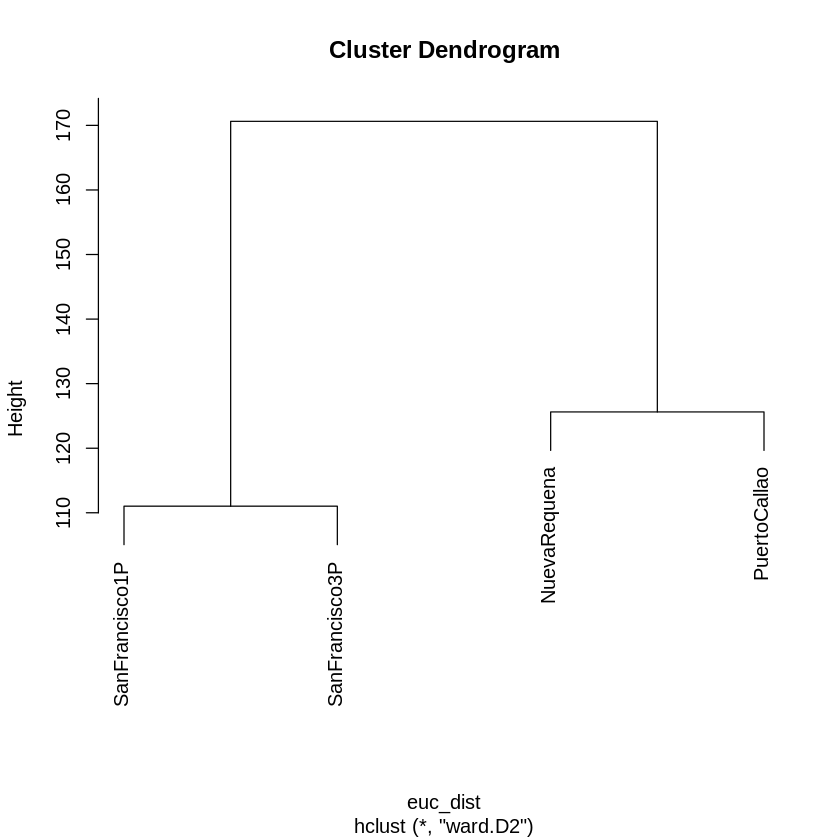

In [53]:
euc_dist <- dist(t(vst_trans_count_tab))
euc_clust <- hclust(euc_dist, method="ward.D2")
plot(euc_clust)

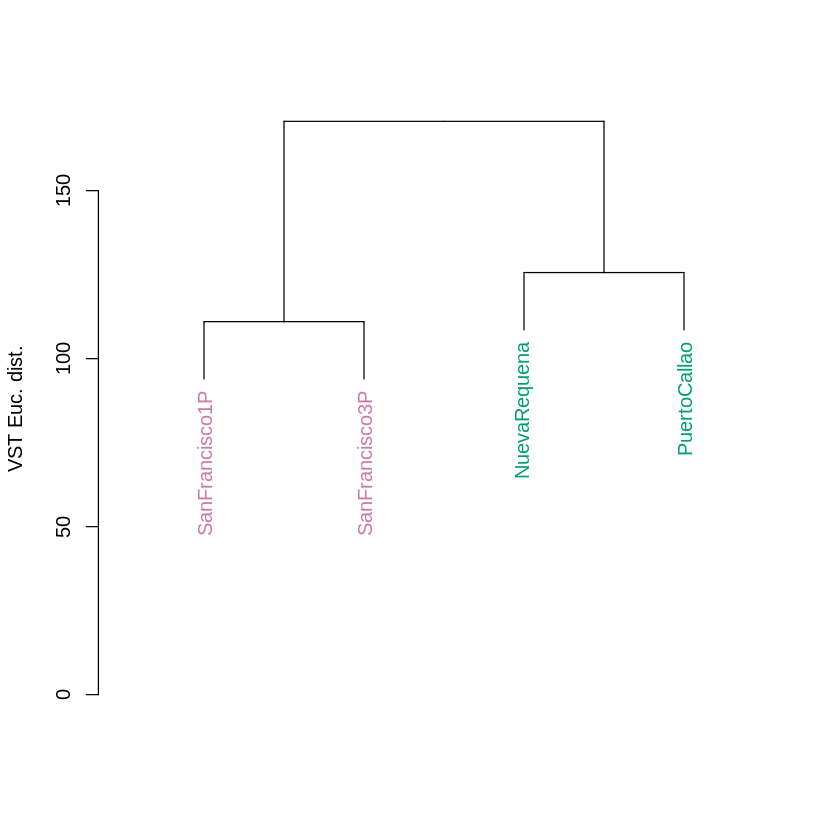

In [54]:
euc_dend <- as.dendrogram(euc_clust, hang=0.1)
dend_cols <- as.character(sample_info_tab$color[order.dendrogram(euc_dend)])
labels_colors(euc_dend) <- dend_cols
plot(euc_dend, ylab="VST Euc. dist.")

# PHYLOSEQ

In [55]:
vst_count_phy <- otu_table(vst_trans_count_tab, taxa_are_rows=T)
sample_info_tab_phy <- sample_data(sample_info_tab)
vst_physeq <- phyloseq(vst_count_phy, sample_info_tab_phy)

In [56]:
vst_pcoa <- ordinate(vst_physeq, method="MDS", distance="euclidean")
eigen_vals <- vst_pcoa$values$Eigenvalues 

In [57]:
write.table(vst_pcoa$vectors, "MDS.tab")
write.table(vst_pcoa$values, "MDS_values.tab")

# CHECKPOINT (11/04/2022)

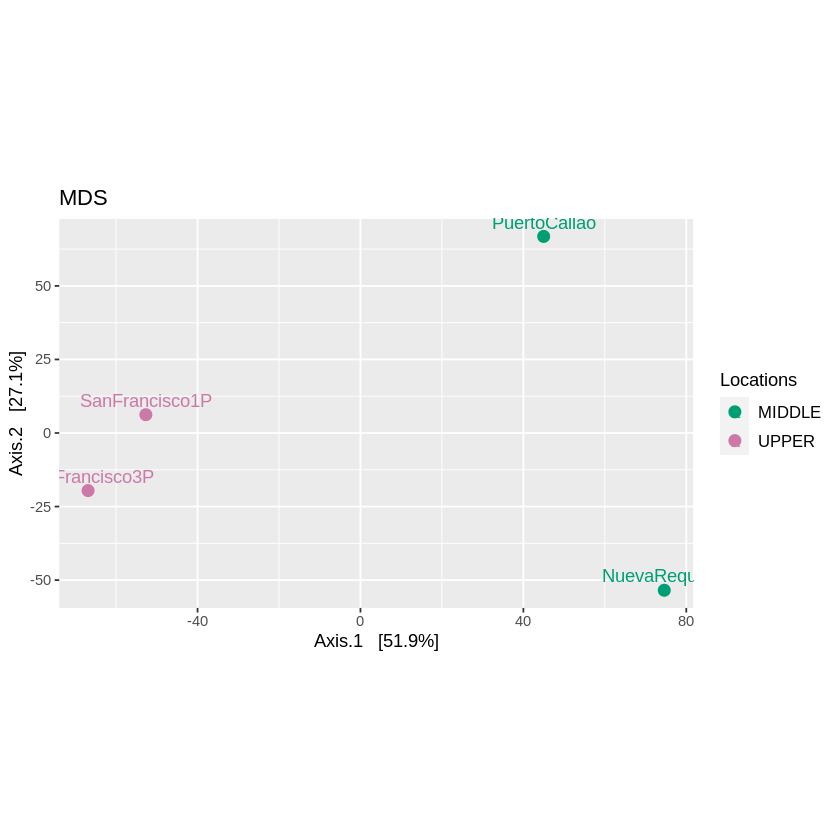

In [58]:
plot_ordination(vst_physeq, vst_pcoa, color="position") + 
  geom_point(size=3) + labs(col="Locations") + 
  geom_text(aes(label=rownames(sample_info_tab), hjust=+0.5, vjust=-0.6)) + 
  coord_fixed(sqrt(eigen_vals[2]/eigen_vals[1])) + ggtitle("MDS") + 
  scale_color_manual(values=unique(sample_info_tab$color[order(sample_info_tab$color)])) + 
  theme(legend.text = element_text(size=10))

In [59]:
#ASV_physeq <- phyloseq(count_tab_phy, tax_tab_phy, sample_info_tab_phy)

In [60]:
count_tab_phy <- otu_table(count_tab, taxa_are_rows=T)

In [61]:
tax_tab_ok <- cbind(tax_tab, tax_tab_sp)
tax_tab_ok <- tax_tab_ok[,-7]

In [62]:
tax_tab_phy <- tax_table(tax_tab_ok)

In [63]:
ASV_physeq <- phyloseq(count_tab_phy, tax_tab_phy, sample_info_tab_phy)

In [64]:
head(count_tab_phy)

,NuevaRequena,PuertoCallao,SanFrancisco1P,SanFrancisco3P
ASV_1,9137,11275,11283,11681
ASV_2,770,132,15075,10338
ASV_3,13733,4895,1419,2066
ASV_4,4376,7539,3805,3681
ASV_5,3173,6993,1444,1369
ASV_6,3835,3461,2578,1874


In [65]:
head(tax_tab_phy)

,Kingdom,Phylum,Class,Order,Family,Genus,Phylum,Class,Order,Family,Genus,Species
ASV_1,Bacteria,Cyanobacteria,Cyanobacteriia,Synechococcales,Cyanobiaceae,Cyanobium_PCC-6307,Cyanobacteria,Cyanobacteriia,Synechococcales,Cyanobiaceae,Cyanobium_PCC-6307,NA
ASV_2,Bacteria,Cyanobacteria,Cyanobacteriia,Synechococcales,Cyanobiaceae,Cyanobium_PCC-6307,Cyanobacteria,Cyanobacteriia,Synechococcales,Cyanobiaceae,Cyanobium_PCC-6307,NA
ASV_3,Bacteria,Cyanobacteria,Cyanobacteriia,Synechococcales,Cyanobiaceae,Cyanobium_PCC-6307,Cyanobacteria,Cyanobacteriia,Synechococcales,Cyanobiaceae,Cyanobium_PCC-6307,NA
ASV_4,Bacteria,Cyanobacteria,Cyanobacteriia,Synechococcales,Cyanobiaceae,Cyanobium_PCC-6307,Cyanobacteria,Cyanobacteriia,Synechococcales,Cyanobiaceae,Cyanobium_PCC-6307,NA
ASV_5,Bacteria,Cyanobacteria,Cyanobacteriia,Synechococcales,Cyanobiaceae,Cyanobium_PCC-6307,Cyanobacteria,Cyanobacteriia,Synechococcales,Cyanobiaceae,Cyanobium_PCC-6307,NA
ASV_6,Bacteria,Verrucomicrobiota,Verrucomicrobiae,Chthoniobacterales,Chthoniobacteraceae,LD29,Verrucomicrobiota,Verrucomicrobiae,Chthoniobacterales,Chthoniobacteraceae,LD29,NA


In [66]:
head(sample_info_tab_phy)

,position,type,color_type,color_Lake,location,ASVs,color
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
NuevaRequena,MIDDLE,lake,#04de1a,#009E73,NuevaRequena,92562,#009E73
PuertoCallao,MIDDLE,lake,#04de1a,#009E73,PuertoCallao,71725,#009E73
SanFrancisco1P,UPPER,lake,#ff49bd,#CC79A7,SanFrancisco1P,106890,#CC79A7
SanFrancisco3P,UPPER,lake,#ff49bd,#CC79A7,SanFrancisco3P,98859,#CC79A7


Warning message in estimate_richness(physeq, split = TRUE, measures = measures):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


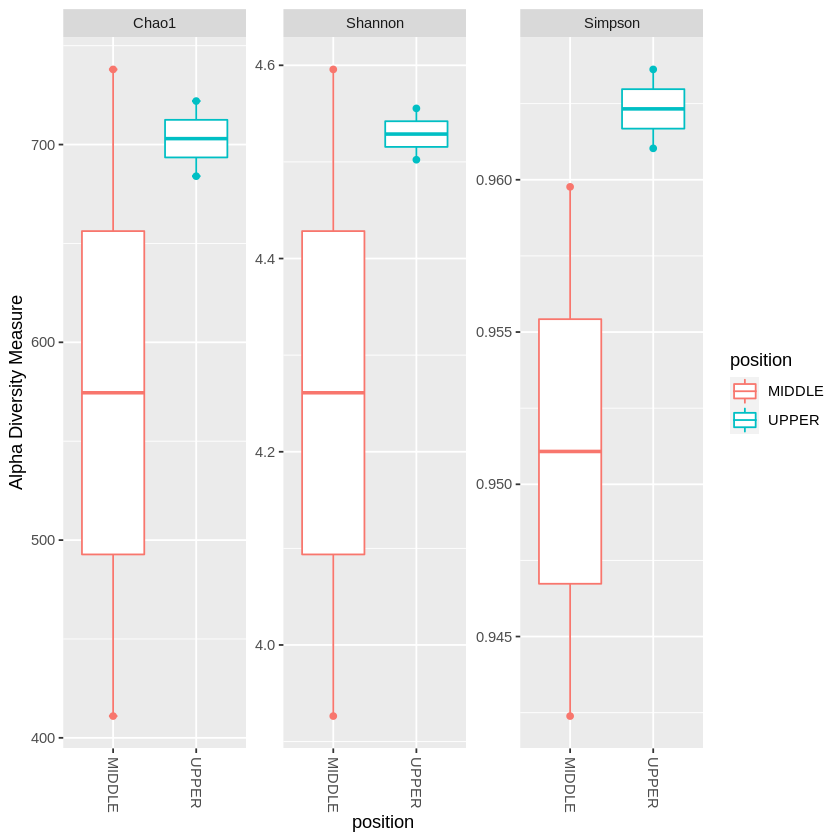

In [67]:
plot_richness(ASV_physeq,x = "position" , color="position", measures=c("Chao1", "Shannon", "Simpson")) + geom_boxplot()

# CHECK POINT (21/05/22)

# STACKPLOT OF CLASSES

In [92]:
clases_counts_tab <- otu_table(tax_glom(ASV_physeq, taxrank="Class"))
clases_tax_vec <- as.vector(tax_table(tax_glom(ASV_physeq, taxrank="Class"))[,3])
rownames(clases_counts_tab) <- as.vector(clases_tax_vec)
unclassified2_tax_counts <- colSums(count_tab) - colSums(clases_counts_tab)
clases_and_unidentified_counts_tab <- rbind(clases_counts_tab, "Unclassified"=unclassified2_tax_counts)
clases_taxa_counts_tab <- clases_and_unidentified_counts_tab
clases_stack.g2 <- merge(clases_stack.g, datos_stack)

Warning message in 1:CN:
“numerical expression has 2 elements: only the first used”
Warning message in if (CN < length(rank_names(physeq))) {:
“la condición tiene longitud > 1 y sólo el primer elemento será usado”
Warning message in (CN + 1):length(rank_names(physeq)):
“numerical expression has 2 elements: only the first used”
Warning message in 1:CN:
“numerical expression has 2 elements: only the first used”
Warning message in if (CN < length(rank_names(physeq))) {:
“la condición tiene longitud > 1 y sólo el primer elemento será usado”
Warning message in (CN + 1):length(rank_names(physeq)):
“numerical expression has 2 elements: only the first used”


In [93]:
identical(colSums(clases_taxa_counts_tab), colSums(count_tab))

[1] TRUE

In [94]:
clases_taxa_proportions_tab <- apply(clases_taxa_counts_tab, 2, function(x) x/sum(x)*100)
temp_filt_clases_taxa_proportions_tab <- data.frame(clases_taxa_proportions_tab[apply(clases_taxa_proportions_tab, 1, max) > 5, ])
filtered2_proportions <- colSums(clases_taxa_proportions_tab) - colSums(temp_filt_clases_taxa_proportions_tab) 
filt_clases_taxa_proportions_tab <- rbind(temp_filt_clases_taxa_proportions_tab, "Other"=filtered2_proportions)
clases_stack <- filt_clases_taxa_proportions_tab
clases_stack$Major_Taxa <- row.names(clases_stack)
clases_stack.g <- gather(clases_stack, Sample, Proportion, -Major_Taxa)
datos_stack<-data.frame("Sample"=row.names(sample_info_tab), "char"=sample_info_tab$position, "color"=sample_info_tab$color, stringsAsFactors=F)                                   

In [95]:
write.csv(clases_stack.g2, "clases_stack_g2.csv")

In [96]:
clases_stack.g2$Sample[clases_stack.g2$Sample == "NuevaRequena"] <- "NuevaRequena"
clases_stack.g2$Sample[clases_stack.g2$Sample == "PuertoCallao"] <- "PuertoCallao"
clases_stack.g2$Sample[clases_stack.g2$Sample == "SanFrancisco1P"] <- "SanFrancisco1P"
clases_stack.g2$Sample[clases_stack.g2$Sample == "SanFrancisco3P"] <- "SanFrancisco3P"

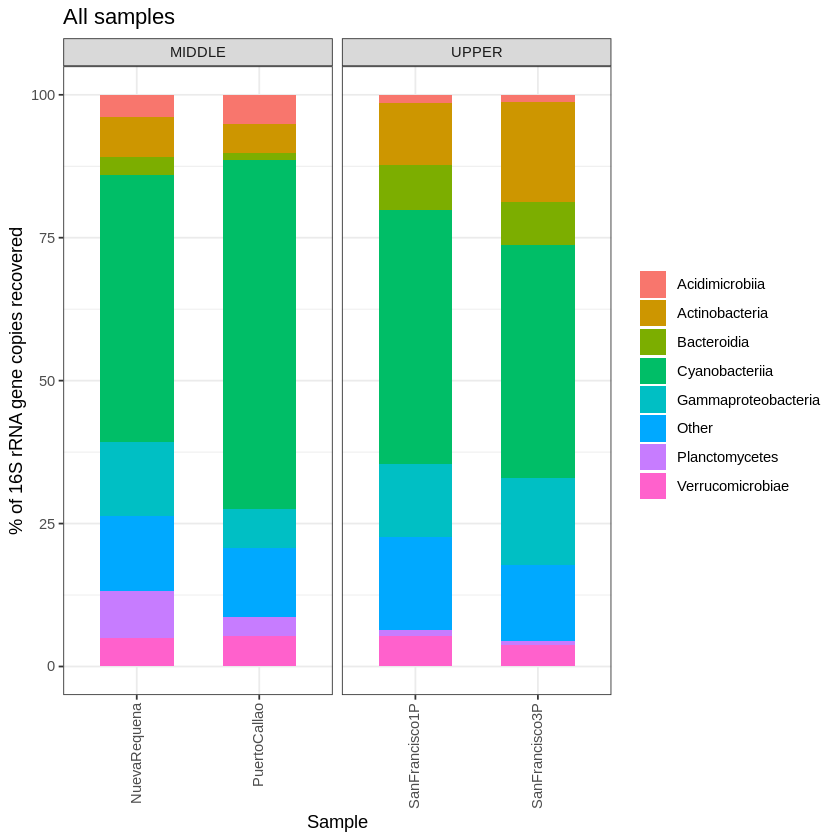

In [97]:
ggplot(clases_stack.g2, aes(x=Sample, y=Proportion, fill=Major_Taxa)) +
  geom_bar(width=0.6, stat="identity") +
  theme_bw() +
  theme(axis.text.x=element_text(angle=90, vjust=0.4, hjust=1), legend.title=element_blank()) +
  labs(x="Sample", y="% of 16S rRNA gene copies recovered", title="All samples") +
 facet_grid(~char, scales = 'free_x', space = 'free_x')

# AMPVIS2

In [98]:
library(ampvis2)

In [99]:
obj <- ASV_physeq
otutable <- data.frame(OTU = rownames(phyloseq::otu_table(obj)@.Data),
                       phyloseq::otu_table(obj)@.Data,
                       phyloseq::tax_table(obj)@.Data,
                       check.names = FALSE)

In [100]:
metadataX <- data.frame(phyloseq::sample_data(obj), 
                       check.names = FALSE)

In [101]:
library(data.table)
metadataX <-setDT(metadataX, keep.rownames = TRUE)[]

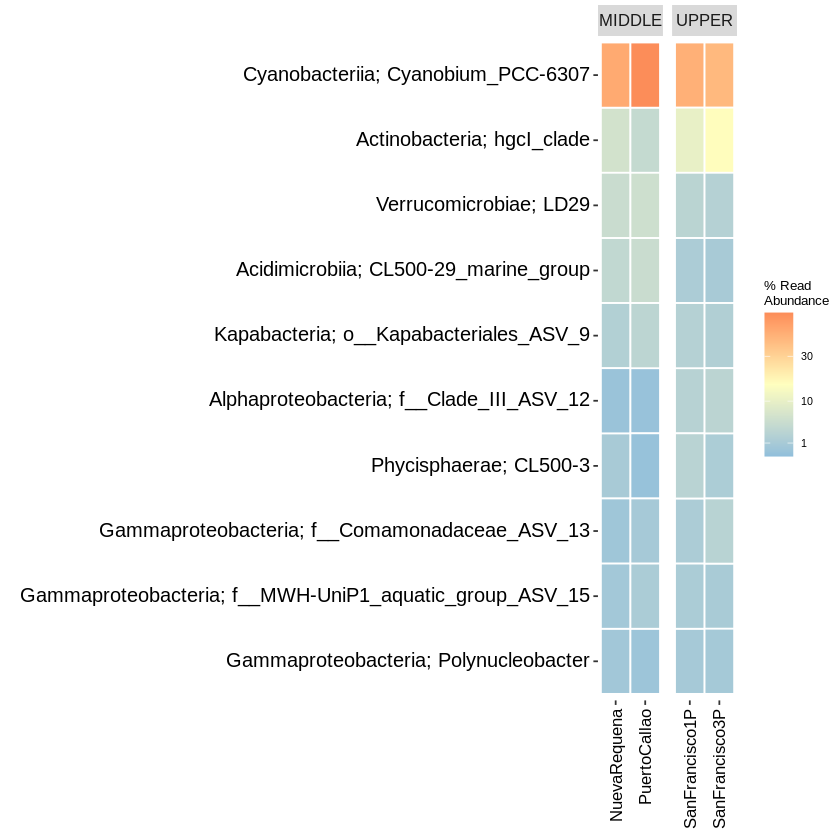

In [102]:
av2 <- amp_load(otutable, metadataX)
#Phylum and Class
amp_heatmap(av2, 
            group_by = "location", 
            facet_by = "position", 
            plot_values = FALSE,
            tax_show = 10,
            tax_aggregate = "Genus",
            tax_add = "Class",
            plot_colorscale = "sqrt",
            plot_legendbreaks = c(1, 10, 30, 60))